In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arrow
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Corsair = mpimg.imread("/Users/markprettyman/Desktop/asv_rl/src/asv/images/Corsair.png")

class ASVVisualizer:
    def __init__(self, width=100, height=100):
        self.width = width
        self.height = height
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.setup_plot()
        
    def setup_plot(self):
        """Setup the plot area"""
        self.ax.set_xlim(-self.width/2, self.width/2)
        self.ax.set_ylim(-self.height/2, self.height/2)
        self.ax.grid(True)
        self.ax.set_aspect('equal')
        self.ax.set_title('ASV with Threats and Other Vessels')
        
    def draw_vessel(self, x, y, heading, size=5):
        """Draw the vessel as an arrow"""
        # Clear previous drawings
        self.ax.clear()
        self.setup_plot()
        
        # Create arrow for vessel
        dx = size * np.cos(heading)
        dy = size * np.sin(heading)
        arrow = Arrow(x, y, dx, dy, width=size/2, color='blue')
        self.ax.add_patch(arrow)
        
        # Draw vessel position circle
        imagebox = OffsetImage(Corsair, zoom=0.1)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        self.ax.add_artist(ab)
        
    def draw_obstacles(self, obstacles):
        """Draw obstacles as circles"""
        for obs in obstacles:
            x, y, radius = obs
            obstacle = Circle((x, y), radius, color='red', alpha=0.5)
            self.ax.add_patch(obstacle)
            
    def draw_goal(self, x, y, radius=3):
        """Draw the goal position"""
        goal = Circle((x, y), radius, color='green', alpha=0.3)
        self.ax.add_patch(goal)
        
    def render(self):
        """Update the visualization"""
        plt.draw()
        plt.pause(0.01)  # Small pause to update the plot 


class ASVEnvironment(gym.Env):
    def __init__(self):
        super(ASVEnvironment, self).__init__()
        
        # Define action and observation space
        # Example: Throttle [-1, 1], Rudder Angle [-30°, 30°] mapped to [-1, 1]
        self.action_space = spaces.Box(
            low=np.array([-1.0, -np.pi/4]),  # [thrust, rudder_angle]
            high=np.array([1.0, np.pi/4]),    # Limit rudder to ±45 degrees
            dtype=np.float32
        )
        
        # Example: Position (x, y), Heading (θ), Velocity (vx, vy), Obstacles, etc.
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf, -np.pi, -1.0, -1.0]),
            high=np.array([np.inf, np.inf, np.pi, 1.0, 1.0]),
            dtype=np.float64
        )
        
        # Initialize environment state
        self.visualizer = None
        self.state = None
        self.obstacles = [[3, 2, 1], [-5, -9, 2]]
        self.goal = np.array([10.0, 10.0])
        self.time_step = 0.1

    def step(self, action):
        # Update vessel dynamics based on action
        throttle, rudder = action
        x, y, heading, vx, vy = self.state
        
        # dynamics update
        acceleration = throttle * 0.1  # throttle-to-acceleration mapping
        heading += rudder * self.time_step  # rudder-to-heading mapping
        vx += acceleration * np.cos(heading) * self.time_step
        vy += acceleration * np.sin(heading) * self.time_step
        x += vx * self.time_step
        y += vy * self.time_step
        
        self.state = np.array([x, y, heading, vx, vy])
        
        # Calculate reward
        distance_to_goal = np.linalg.norm(self.goal - np.array([x, y]))
        reward = -distance_to_goal  # Penalize distance from goal
        
        # Check if the episode is done
        done = distance_to_goal < 0.5  # Example goal threshold
        if np.abs(x) > 20 or np.abs(y) > 20:  # Example out-of-bounds condition
            done = True
            reward -= 100  # Penalize going out of bounds
        
        return self.state, reward, done, False, {}
    
    def reset(self, seed=None, options=None):
        # Reset the state of the environment
        self.state = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # [x, y, heading, vx, vy]
        return self.state, {}

    def render(self):
        if self.visualizer is None:
            self.visualizer = ASVVisualizer()
            
        # Extract position and heading from state
        x, y, heading = self.state[:3]
        
        # Draw everything
        self.visualizer.draw_vessel(x, y, heading)
        self.visualizer.draw_obstacles(self.obstacles)
        self.visualizer.draw_goal(*self.goal)
        self.visualizer.render()

    def close(self):
        if self.visualizer is not None:
            plt.close(self.visualizer.fig)  
            self.visualizer = None




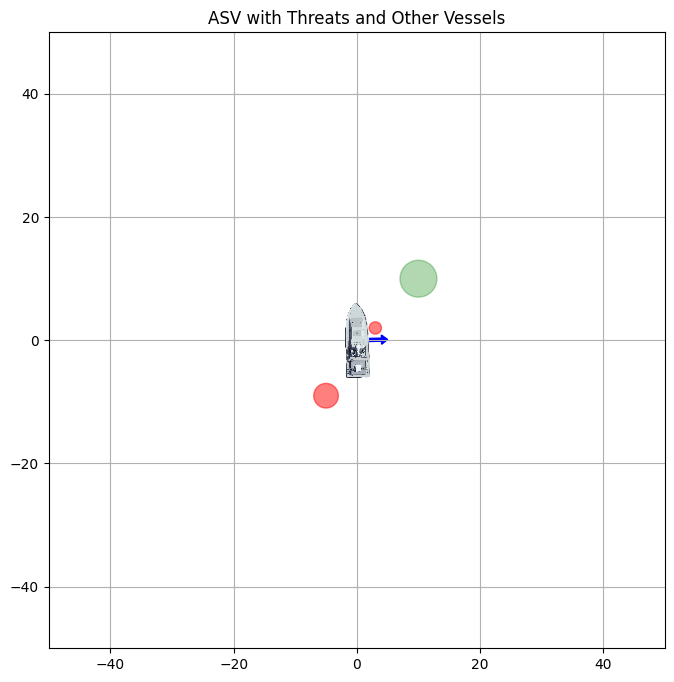

State: [-3.72197975e-04 -9.27424749e-06  2.49123569e-02 -3.72197975e-03
 -9.27424749e-05], Reward: -14.142405367654652


<Figure size 640x480 with 0 Axes>

State: [-9.25343630e-04 -3.97182652e-05  1.16464429e-01 -5.53145655e-03
 -3.04440177e-04], Reward: -14.142818039405629


<Figure size 640x480 with 0 Axes>

State: [-1.50871850e-03 -7.26051362e-05  8.06357706e-02 -5.83374874e-03
 -3.28868710e-04], Reward: -14.14325382485559


<Figure size 640x480 with 0 Axes>

State: [-1.71610009e-03 -9.64269402e-05  2.41049815e-02 -2.07381587e-03
 -2.38218039e-04], Reward: -14.143417320255654


<Figure size 640x480 with 0 Axes>

State: [-1.19512641e-03 -9.85845718e-05  2.97351962e-02  5.20973685e-03
 -2.15763160e-05], Reward: -14.143050436789974


In [18]:
env = ASVEnvironment()

state, info = env.reset()
for _ in range(5):
    action = env.action_space.sample()  # Random action
    state, reward, done, truncated, info = env.step(action)
    env.render()
    print(f"State: {state}, Reward: {reward}")
    if done or truncated:
        print("Episode finished!")
        break

env.close()